In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.impute import SimpleImputer
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import mahalanobis



In [ ]:
titanic = sns.load_dataset('titanic')

# Extracting necessary columns
columns_of_interest = ['age', 'sex', 'pclass', 'survived']
titanic_subset = titanic[columns_of_interest]

# Imputing missing values in the 'age' column with the mean
imputer = SimpleImputer(strategy='mean')
titanic_subset['age'] = imputer.fit_transform(titanic_subset[['age']])

titanic_subset['sex'] = titanic_subset['sex'].map({'female': 0, 'male': 1})

titanic_subset.head()


<ipython-input-31-ad901d0ad95a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_subset['age'] = imputer.fit_transform(titanic_subset[['age']])
<ipython-input-31-ad901d0ad95a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_subset['sex'] = titanic_subset['sex'].map({'female': 0, 'male': 1})


,age,sex,pclass,survived
0,22.0,1,3,0
1,38.0,0,1,1
2,26.0,0,3,1
3,35.0,0,1,1
4,35.0,1,3,0


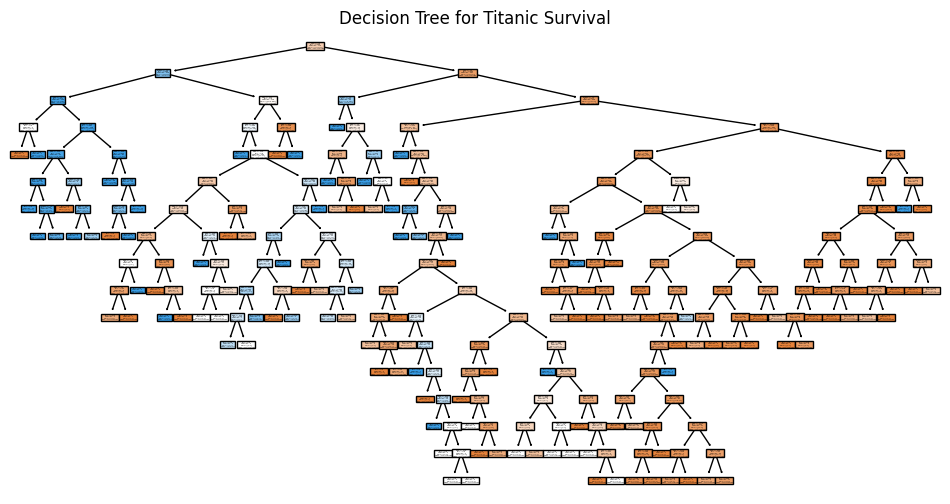

in sample error: 0.1221910112359551 cross validation error: 0.19860649049023915


In [ ]:
# Splitting the dataset into training and testing sets
X = titanic_subset[['age', 'sex', 'pclass']]
y = titanic_subset['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Plotting the decision tree
plt.figure(figsize=(12, 6))
plot_tree(clf, feature_names=['age', 'sex', 'pclass'], class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree for Titanic Survival")
plt.show()

# In-sample error
in_sample_accuracy = clf.score(X_train, y_train)
in_sample_error = 1 - in_sample_accuracy

cv_scores = cross_val_score(clf, X, y, cv=5)  # 5-fold cross-validation
cv_error = 1 - cv_scores.mean()

print('in sample error:', in_sample_error, 'cross validation error:', cv_error)



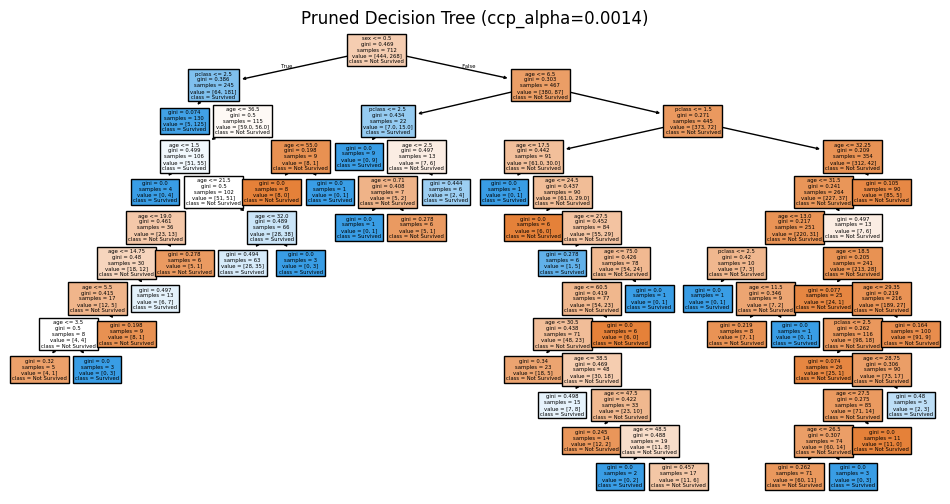

Original Tree In-Sample Error: 0.1222
Original Tree Cross-Validation Error: 0.1986
Pruned Tree In-Sample Error: 0.1433
Pruned Tree Cross-Validation Error: 0.2076


In [ ]:
# Cost Complexity Pruning: Determine effective alpha values
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # Alpha values
impurities = path.impurities  # Total leaf impurities

# Train decision trees for each alpha
trees = []
for ccp_alpha in ccp_alphas:
    clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_pruned.fit(X_train, y_train)
    trees.append(clf_pruned)

# Cross-validation to find the best alpha
cv_errors = [1 - cross_val_score(tree, X_train, y_train, cv=5).mean() for tree in trees]
best_alpha_idx = cv_errors.index(min(cv_errors))
best_alpha = ccp_alphas[best_alpha_idx]

# Train the pruned tree with the best alpha
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Plotting the pruned tree
plt.figure(figsize=(12, 6))
plot_tree(pruned_tree, feature_names=['age', 'sex', 'pclass'], class_names=['Not Survived', 'Survived'], filled=True)
plt.title(f"Pruned Decision Tree (ccp_alpha={best_alpha:.4f})")
plt.show()

# Misclassification errors after pruning
# In-sample error for pruned tree
in_sample_accuracy_pruned = pruned_tree.score(X_train, y_train)
in_sample_error_pruned = 1 - in_sample_accuracy_pruned

# Cross-validation error for pruned tree
cv_error_pruned = 1 - cross_val_score(pruned_tree, X, y, cv=5).mean()

# Results comparison
print(f"Original Tree In-Sample Error: {in_sample_error:.4f}")
print(f"Original Tree Cross-Validation Error: {cv_error:.4f}")
print(f"Pruned Tree In-Sample Error: {in_sample_error_pruned:.4f}")
print(f"Pruned Tree Cross-Validation Error: {cv_error_pruned:.4f}")


In [ ]:

# Fitting a Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# In-sample error (Logistic Regression)
in_sample_accuracy_logreg = logreg.score(X_train, y_train)
in_sample_error_logreg = 1 - in_sample_accuracy_logreg

# Cross-validation error (Logistic Regression)
cv_scores_logreg = cross_val_score(logreg, X, y, cv=5)  # 5-fold cross-validation
cv_error_logreg = 1 - cv_scores_logreg.mean()

# Compare the errors
print(f"Logistic Regression In-Sample Error: {in_sample_error_logreg:.4f}")
print(f"Logistic Regression Cross-Validation Error: {cv_error_logreg:.4f}")

# Decision Tree model comparison (from previous code)
print(f"Decision Tree In-Sample Error: {in_sample_error:.4f}")
print(f"Decision Tree Cross-Validation Error: {cv_error:.4f}")


Logistic Regression In-Sample Error: 0.2079
Logistic Regression Cross-Validation Error: 0.2121
Decision Tree In-Sample Error: 0.1222
Decision Tree Cross-Validation Error: 0.1986


In [ ]:

# Split the data into training and testing sets
X = titanic_subset[['age', 'sex', 'pclass']]
y = titanic_subset['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a KNN classifier with default parameters
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate using resubstitution loss (in-sample)
resub_accuracy = accuracy_score(y_train, knn.predict(X_train))
resub_loss = 1 - resub_accuracy

# Evaluate using cross-validation (5-fold by default)
cv_scores = cross_val_score(knn, X, y, cv=5)
cv_loss = 1 - cv_scores.mean()

# Evaluate using k-fold loss (explicit k=10)
kfold_scores = cross_val_score(knn, X, y, cv=10)
kfold_loss = 1 - kfold_scores.mean()

# Display the results
print(f"Resubstitution Loss (In-sample): {resub_loss:.4f}")
print(f"Cross-Validation Loss (5-Fold): {cv_loss:.4f}")
print(f"K-Fold Loss (10-Fold): {kfold_loss:.4f}")


Resubstitution Loss (In-sample): 0.1742
Cross-Validation Loss (5-Fold): 0.2480
K-Fold Loss (10-Fold): 0.2177


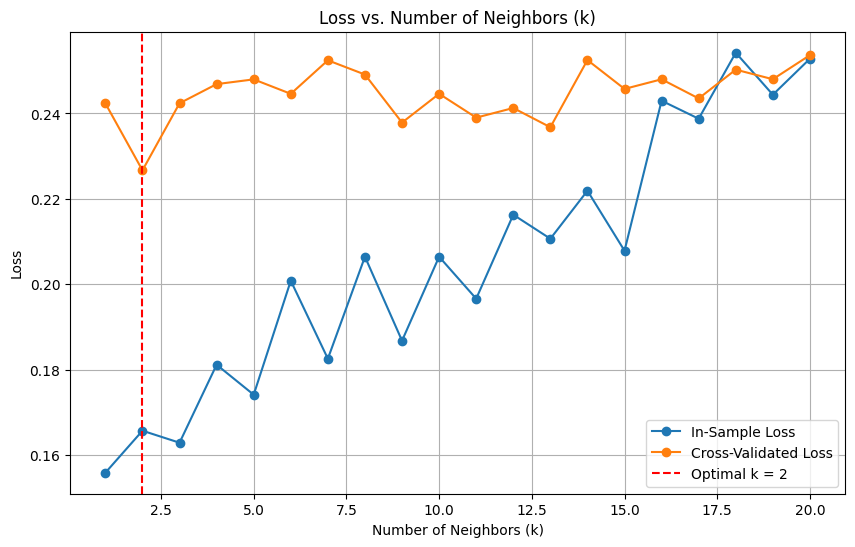

Optimal number of neighbors (k): 2
Cross-Validated Loss at optimal k: 0.2267


In [ ]:
# Define the range for number of neighbors
k_values = range(1, 21)

# Store losses
in_sample_losses = []
cv_losses = []

# Iterate through each value of k
for k in k_values:
    # Create and fit the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Compute in-sample loss
    in_sample_accuracy = knn.score(X_train, y_train)
    in_sample_losses.append(1 - in_sample_accuracy)

    # Compute cross-validated loss
    cv_scores = cross_val_score(knn, X, y, cv=5)
    cv_losses.append(1 - cv_scores.mean())

# Find the optimal number of neighbors
optimal_k = k_values[np.argmin(cv_losses)]

# Plot the losses against k
plt.figure(figsize=(10, 6))
plt.plot(k_values, in_sample_losses, label="In-Sample Loss", marker='o')
plt.plot(k_values, cv_losses, label="Cross-Validated Loss", marker='o')
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("Loss vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Display the optimal number of neighbors and corresponding cross-validated loss
print(f"Optimal number of neighbors (k): {optimal_k}")
print(f"Cross-Validated Loss at optimal k: {cv_losses[optimal_k - 1]:.4f}")


In [ ]:

# Define a custom Mahalanobis metric
def mahalanobis_metric(x, y, VI=None):
    return mahalanobis(x, y, VI)

# Distance metrics to evaluate
distance_metrics = ['euclidean', 'chebyshev', 'hamming']

# Store results
results = []

# Iterate through each distance metric
for metric in distance_metrics:
    knn = KNeighborsClassifier(metric=metric)
    knn.fit(X_train, y_train)

    # In-sample performance
    in_sample_accuracy = accuracy_score(y_train, knn.predict(X_train))
    in_sample_loss = 1 - in_sample_accuracy

    # Cross-validated performance
    cv_scores = cross_val_score(knn, X, y, cv=5)
    cv_loss = 1 - cv_scores.mean()

    # Save results
    results.append((metric, in_sample_loss, cv_loss))

# Evaluate with Mahalanobis distance
VI = np.linalg.inv(np.cov(X_train, rowvar=False))
knn_mahalanobis = KNeighborsClassifier(metric=mahalanobis_metric, metric_params={'VI': VI})
knn_mahalanobis.fit(X_train, y_train)
in_sample_accuracy = accuracy_score(y_train, knn_mahalanobis.predict(X_train))
in_sample_loss = 1 - in_sample_accuracy
cv_scores = cross_val_score(knn_mahalanobis, X, y, cv=5)
cv_loss = 1 - cv_scores.mean()
results.append(('mahalanobis', in_sample_loss, cv_loss))

# Display results
print("Performance of KNN Classifier with Different Distance Metrics:")
for metric, in_loss, cv_loss in results:
    print(f"Metric: {metric}, In-Sample Loss: {in_loss:.4f}, Cross-Validated Loss: {cv_loss:.4f}")


Performance of KNN Classifier with Different Distance Metrics:
Metric: euclidean, In-Sample Loss: 0.1742, Cross-Validated Loss: 0.2480
Metric: chebyshev, In-Sample Loss: 0.1910, Cross-Validated Loss: 0.2648
Metric: hamming, In-Sample Loss: 0.2444, Cross-Validated Loss: 0.2951
Metric: mahalanobis, In-Sample Loss: 0.1629, Cross-Validated Loss: 0.2009


In [ ]:


# Fit KNN with the optimal k
optimal_k = 2
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn_cv_scores = cross_val_score(knn, X, y, cv=5)
knn_cv_accuracy = knn_cv_scores.mean()
knn_cv_loss = 1 - knn_cv_accuracy

# Fit Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg_cv_scores = cross_val_score(log_reg, X, y, cv=5)
log_reg_cv_accuracy = log_reg_cv_scores.mean()
log_reg_cv_loss = 1 - log_reg_cv_accuracy


print(f"KNN (k={optimal_k}) Cross-Validated Accuracy: {knn_cv_accuracy:.4f}, Loss: {knn_cv_loss:.4f}")
print(f"Logistic Regression Cross-Validated Accuracy: {log_reg_cv_accuracy:.4f}, Loss: {log_reg_cv_loss:.4f}")


KNN (k=2) Cross-Validated Accuracy: 0.7733, Loss: 0.2267
Logistic Regression Cross-Validated Accuracy: 0.7879, Loss: 0.2121


In [ ]:
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

In [ ]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
# Calculate averages
average_red = red_wine.mean()
average_white= white_wine.mean()

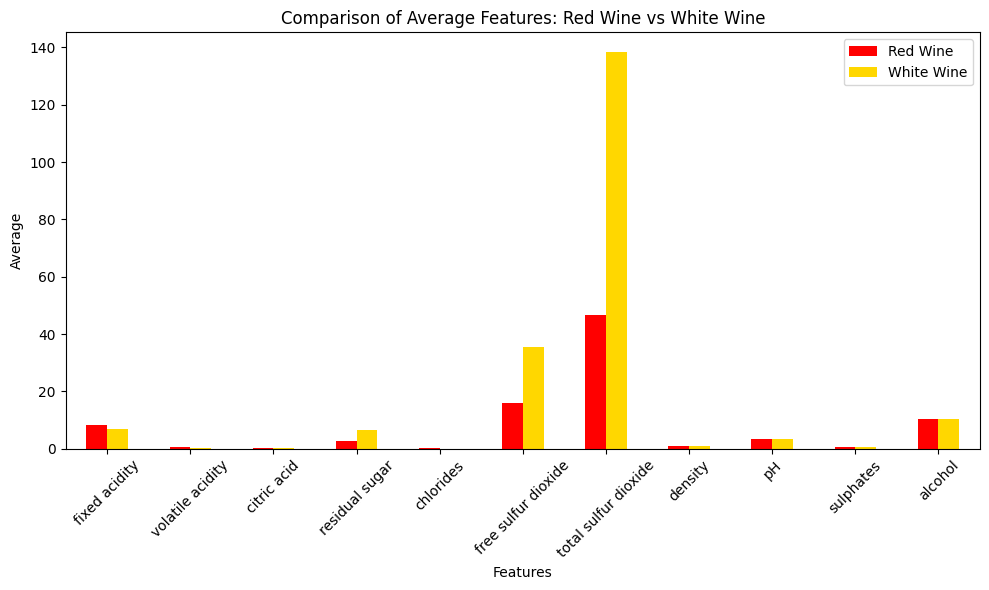

                       Red Wine  White Wine
fixed acidity          8.319637    6.854788
volatile acidity       0.527821    0.278241
citric acid            0.270976    0.334192
residual sugar         2.538806    6.391415
chlorides              0.087467    0.045772
free sulfur dioxide   15.874922   35.308085
total sulfur dioxide  46.467792  138.360657
density                0.996747    0.994027
pH                     3.311113    3.188267
sulphates              0.658149    0.489847
alcohol               10.422983   10.514267


In [ ]:
# Combine the averages
averages = pd.DataFrame({
    'Red Wine': average_red,
    'White Wine': average_white
}).drop('quality')


# Plot the averages
averages.plot(kind='bar', figsize=(10, 6), color=['red', 'gold'])
plt.title('Comparison of Average Features: Red Wine vs White Wine')
plt.ylabel('Average')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze the results
print(averages)

In [ ]:
# Calculate correlations with quality
red_corr = red_wine.corr()['quality'].drop('quality')  #self correlation is not useful here
white_corr = white_wine.corr()['quality'].drop('quality')

# Find the most relevant variables
most_relevant_red = red_corr.abs().idxmax()
most_relevant_white = white_corr.abs().idxmax()

# Print results
print("Red Wine Correlations:\n", red_corr)
print("\nMost relevant variable for Red Wine:", most_relevant_red, "with correlation:", red_corr[most_relevant_red])

print("\nWhite Wine Correlations:\n", white_corr)
print("\nMost relevant variable for White Wine:", most_relevant_white, "with correlation:", white_corr[most_relevant_white])

Red Wine Correlations:
 fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64

Most relevant variable for Red Wine: alcohol with correlation: 0.47616632400113656

White Wine Correlations:
 fixed acidity          -0.113663
volatile acidity       -0.194723
citric acid            -0.009209
residual sugar         -0.097577
chlorides              -0.209934
free sulfur dioxide     0.008158
total sulfur dioxide   -0.174737
density                -0.307123
pH                      0.099427
sulphates               0.053678
alcohol                 0.435575
Name: quality, dtype: float64

Most relevant variable for White Wine: alcohol with correlation: 0.43557471546

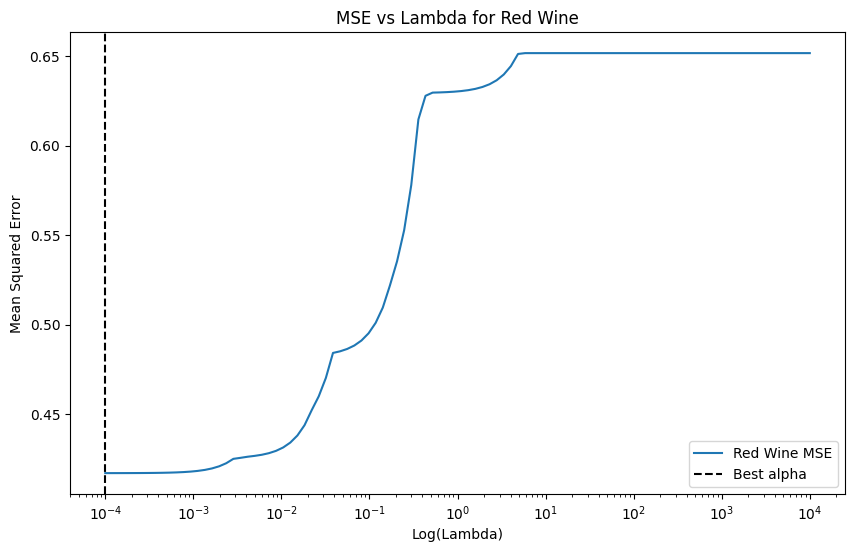

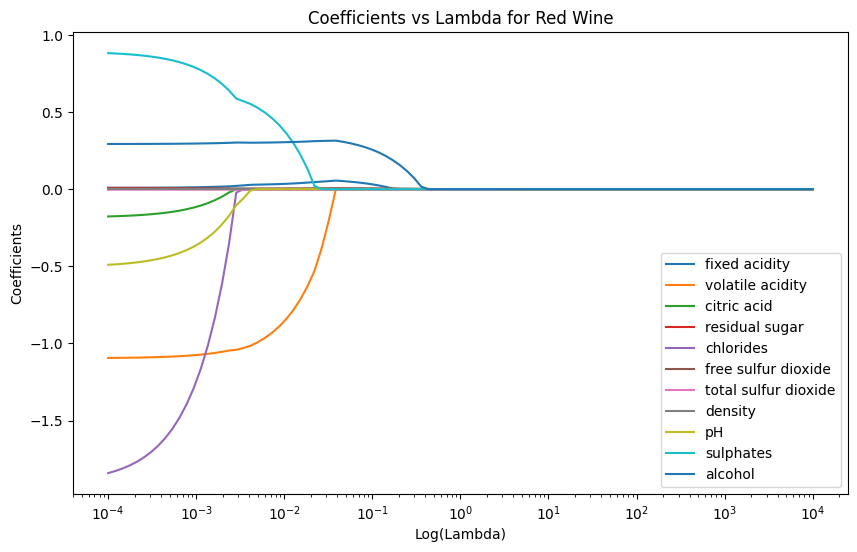

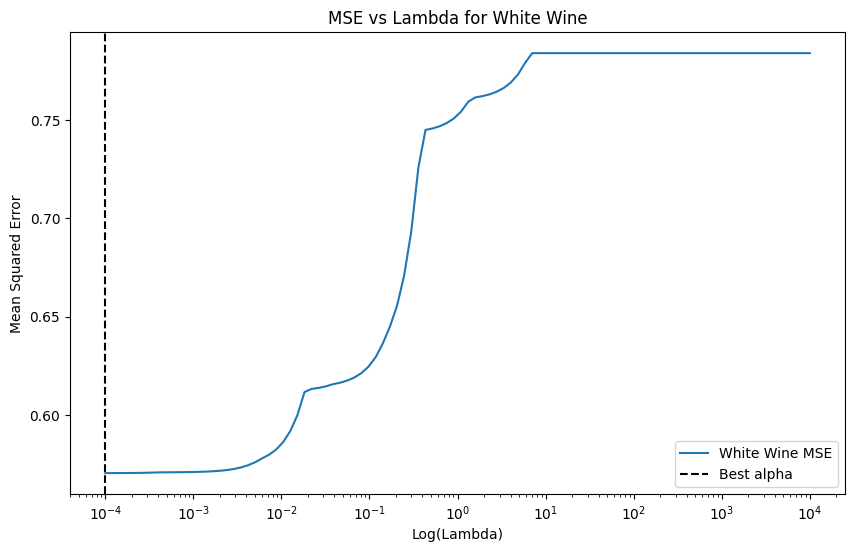

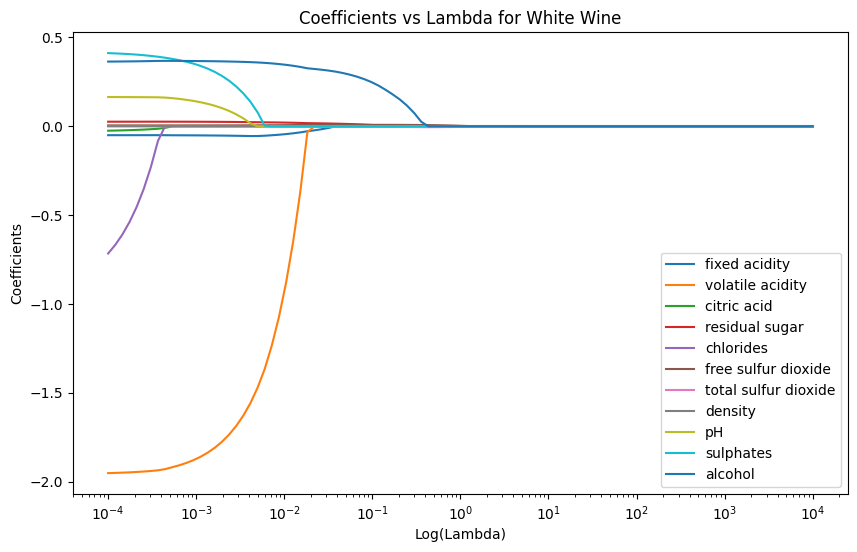

In [ ]:


# Separate features and target for red wine
X_red = red_wine.drop(columns=['quality'])
y_red = red_wine['quality']

# Separate features and target for white wine
X_white = white_wine.drop(columns=['quality'])
y_white = white_wine['quality']

# Define a range of alphas (regularization strength) to try
alphas = np.logspace(-4, 4, 100)

# Initialize lists to store MSE and coefficients for each alpha
mse_red = []
coef_path_red = np.zeros((len(alphas), X_red.shape[1]))

# Fit Lasso model with a range of alphas for red wine
for i, alpha in enumerate(alphas):
    lasso_red = Lasso(alpha=alpha)
    lasso_red.fit(X_red, y_red)
    y_pred_red = lasso_red.predict(X_red)
    mse_red.append(mean_squared_error(y_red, y_pred_red))
    coef_path_red[i, :] = lasso_red.coef_

# Initialize lists to store MSE and coefficients for each alpha
mse_white = []
coef_path_white = np.zeros((len(alphas), X_white.shape[1]))

# Fit Lasso model with a range of alphas for white wine
for i, alpha in enumerate(alphas):
    lasso_white = Lasso(alpha=alpha)
    lasso_white.fit(X_white, y_white)
    y_pred_white = lasso_white.predict(X_white)
    mse_white.append(mean_squared_error(y_white, y_pred_white))
    coef_path_white[i, :] = lasso_white.coef_

# Plot MSE vs alpha for red wine
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_red, label='Red Wine MSE')
plt.xscale('log')
plt.xlabel('Log(Lambda)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Lambda for Red Wine')
plt.axvline(x=alphas[np.argmin(mse_red)], linestyle='--', color='k', label='Best alpha')
plt.legend()
plt.show()

# Plot Coefficients vs alpha for red wine
plt.figure(figsize=(10, 6))
for i in range(X_red.shape[1]):
    plt.plot(alphas, coef_path_red[:, i], label=X_red.columns[i])
plt.xscale('log')
plt.xlabel('Log(Lambda)')
plt.ylabel('Coefficients')
plt.title('Coefficients vs Lambda for Red Wine')
plt.legend()
plt.show()

# Plot MSE vs alpha for white wine
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_white, label='White Wine MSE')
plt.xscale('log')
plt.xlabel('Log(Lambda)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Lambda for White Wine')
plt.axvline(x=alphas[np.argmin(mse_white)], linestyle='--', color='k', label='Best alpha')
plt.legend()
plt.show()

# Plot Coefficients vs alpha for white wine
plt.figure(figsize=(10, 6))
for i in range(X_white.shape[1]):
    plt.plot(alphas, coef_path_white[:, i], label=X_white.columns[i])
plt.xscale('log')
plt.xlabel('Log(Lambda)')
plt.ylabel('Coefficients')
plt.title('Coefficients vs Lambda for White Wine')
plt.legend()
plt.show()


In [ ]:


# Initialize lists to store MSE and coefficients for each alpha
mse_red = []
coef_path_red = np.zeros((len(alphas), X_red.shape[1]))

# Fit Lasso model with a range of alphas for red wine
for i, alpha in enumerate(alphas):
    lasso_red = Lasso(alpha=alpha)
    lasso_red.fit(X_red, y_red)
    y_pred_red = lasso_red.predict(X_red)
    mse_red.append(mean_squared_error(y_red, y_pred_red))
    coef_path_red[i, :] = lasso_red.coef_

# Find the best alpha that minimizes MSE
best_alpha = alphas[np.argmin(mse_red)]

# Fit the Lasso model with the best alpha
lasso_red_best = Lasso(alpha=best_alpha)
lasso_red_best.fit(X_red, y_red)

# Identify the features selected by Lasso (non-zero coefficients)
selected_features = X_red.columns[lasso_red_best.coef_ != 0]
print("Selected features by Lasso:", selected_features)

# Use only the selected features for KNN regression
X_red_selected = X_red[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_red_selected, y_red, test_size=0.2, random_state=42)

# Initialize and train the KNN regression model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the KNN model using MSE
mse_knn = mean_squared_error(y_test, y_pred_knn)
print("Mean Squared Error of KNN Model:", mse_knn)




Selected features by Lasso: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH',
       'sulphates', 'alcohol'],
      dtype='object')
Mean Squared Error of KNN Model: 0.5319999999999999


In [ ]:


# Prepare the data (assuming X_red_selected and y_red are already defined)
X_train, X_test, y_train, y_test = train_test_split(X_red_selected, y_red, test_size=0.2, random_state=42)

# Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)

# KNN Regression model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Performance metrics for Linear Regression
mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)
r2_lin_reg = r2_score(y_test, y_pred_lin_reg)

# Performance metrics for KNN Regression
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Print the performance of both models
print(f"Linear Regression - MSE: {mse_lin_reg}, R²: {r2_lin_reg}")
print(f"KNN Regression - MSE: {mse_knn}, R²: {r2_knn}")


Linear Regression - MSE: 0.39055762385079595, R²: 0.4023655362106202
KNN Regression - MSE: 0.5319999999999999, R²: 0.18592925775938085
